## Setting up the notebook

High-level configs

In [1]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv

# Load environment variables from .env file. Adjust the path to the .env file as needed.
load_dotenv(dotenv_path='../.env')

# Enable asyncio in Jupyter
import asyncio
import nest_asyncio

nest_asyncio.apply()

#  Add the package to the path (required if you are running this notebook from the examples folder)
import sys
sys.path.append('../../')


Import required packages

In [3]:
import json
import numpy as np
from openai import AsyncOpenAI
import pandas as pd
from pydantic import BaseModel
from tqdm.auto import tqdm

from lattereview.providers import OpenAIProvider
from lattereview.providers import OllamaProvider
from lattereview.providers import LiteLLMProvider
from lattereview.agents import ScoringReviewer
from lattereview.workflows import ReviewWorkflow

## Data

100%|██████████| 12/12 [00:00<00:00, 633.48it/s]


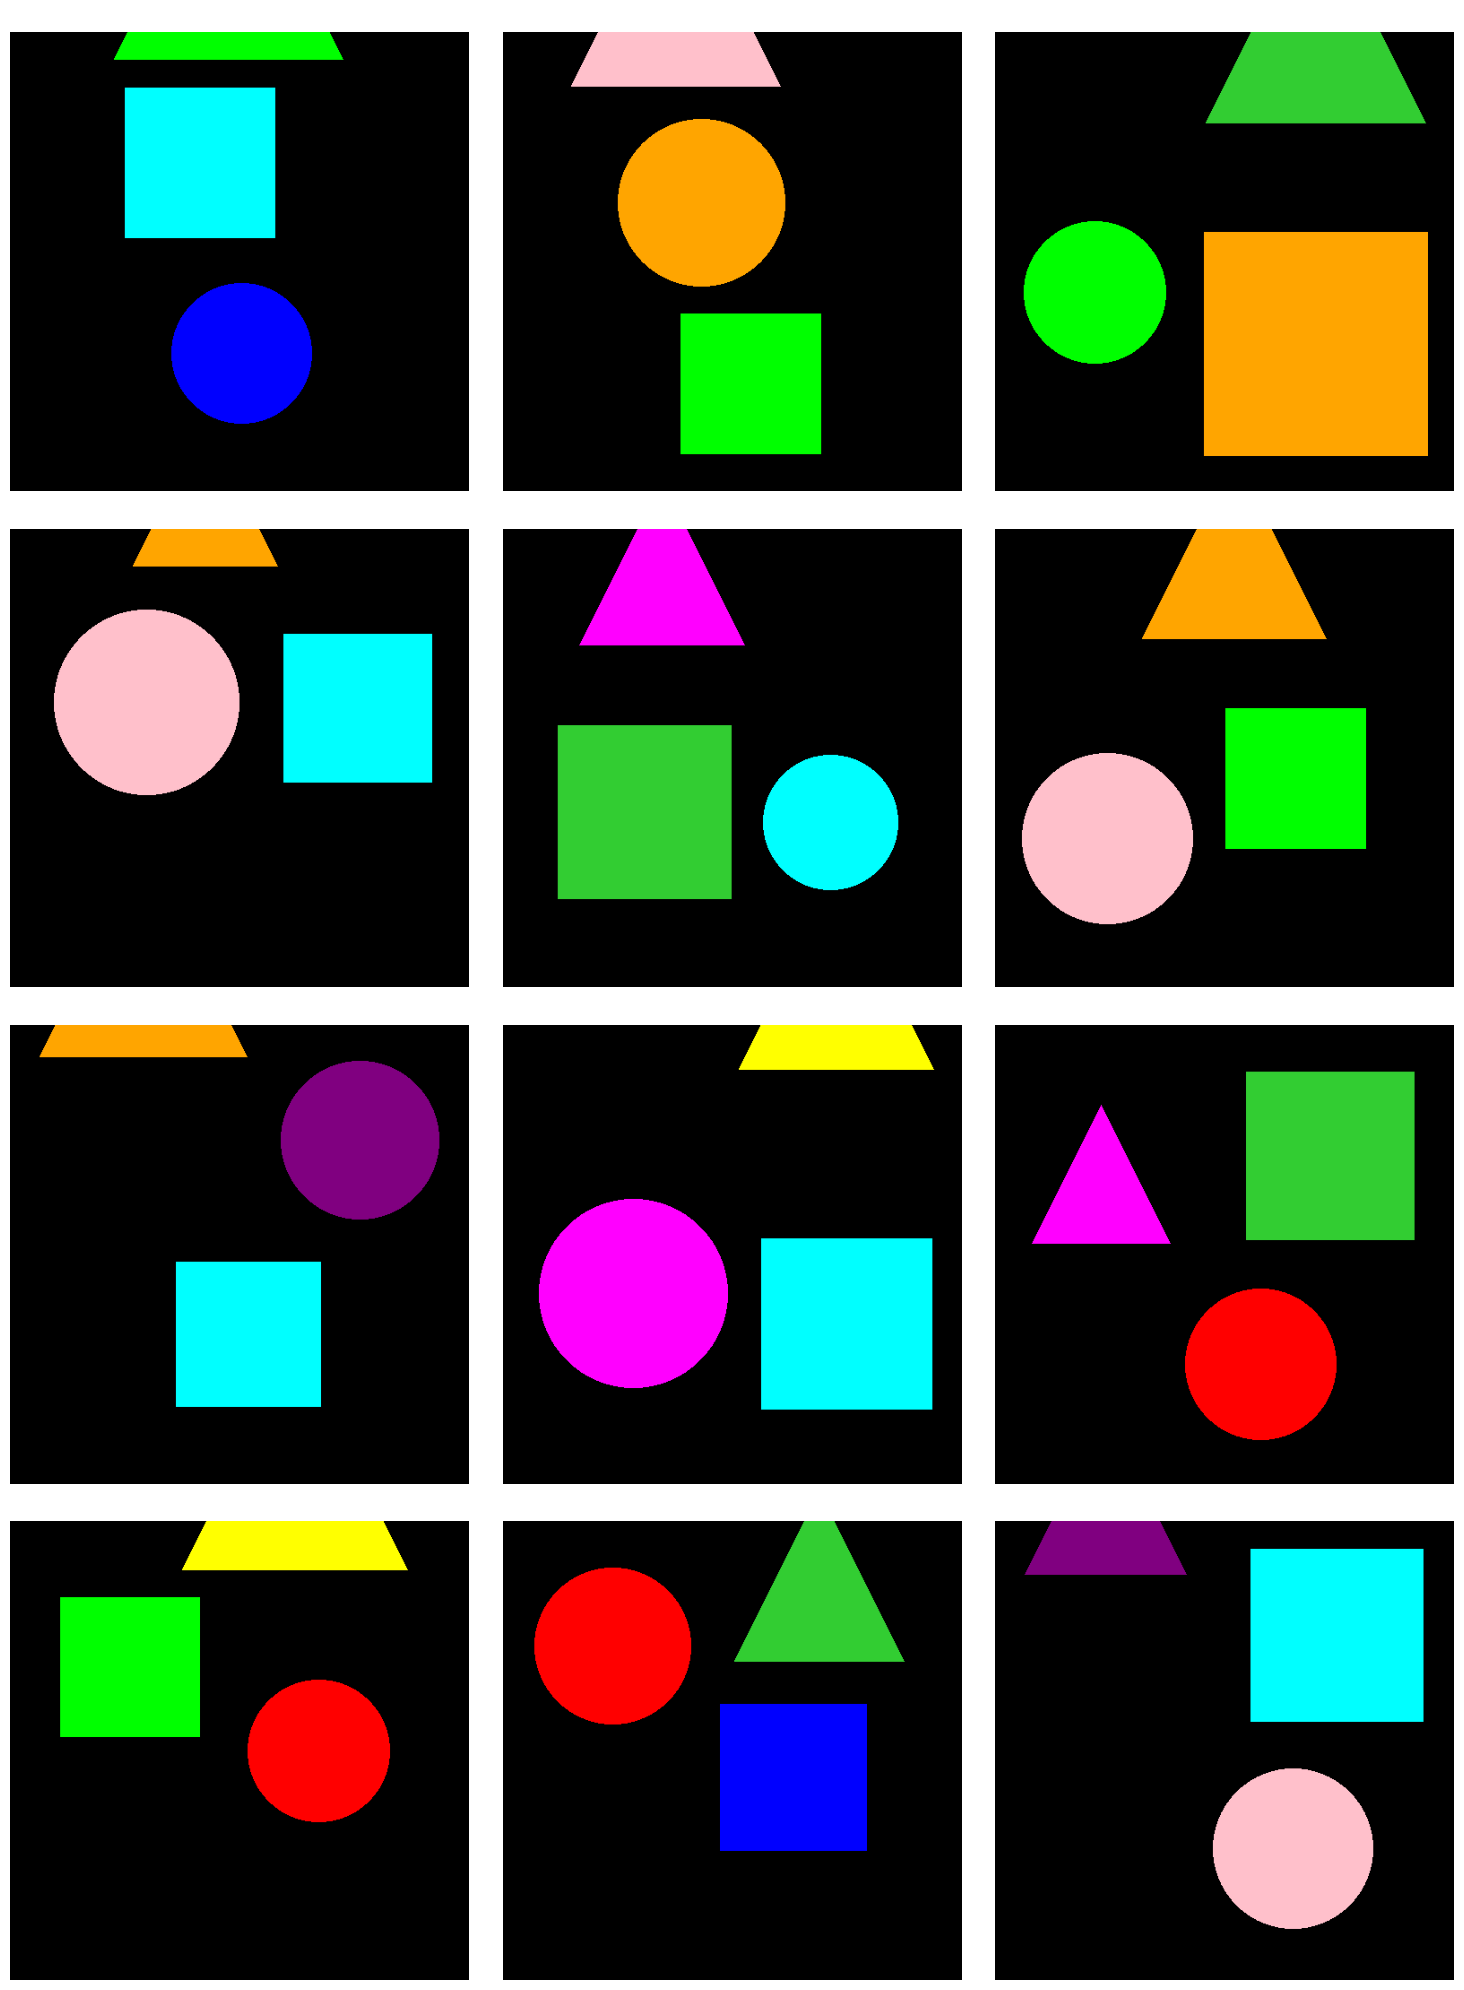


Generation success rate: 100.0 %


,image_path,description,target,color_circle,color_square,color_triangle
0,data/image_0.jpg,"Image 1 with blue circle, cyan square, green t...",circle,blue,cyan,green
1,data/image_1.jpg,"Image 2 with orange circle, pink triangle, gre...",circle,orange,green,pink
2,data/image_2.jpg,"Image 3 with orange square, lime triangle, gre...",triangle,green,orange,lime
3,data/image_3.jpg,"Image 4 with orange triangle, cyan square, pin...",square,pink,cyan,orange
4,data/image_4.jpg,"Image 5 with cyan circle, lime square, magenta...",triangle,cyan,lime,magenta
5,data/image_5.jpg,"Image 6 with green square, orange triangle, pi...",triangle,pink,green,orange
6,data/image_6.jpg,"Image 7 with cyan square, purple circle, orang...",square,purple,cyan,orange
7,data/image_7.jpg,"Image 8 with magenta circle, cyan square, yell...",triangle,magenta,cyan,yellow
8,data/image_8.jpg,"Image 9 with lime square, red circle, magenta ...",circle,red,lime,magenta
9,data/image_9.jpg,"Image 10 with green square, red circle, yellow...",triangle,red,green,yellow


In [33]:
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

os.makedirs("data", exist_ok=True)

colors = {
    "red": (255, 0, 0), "green": (0, 255, 0), "blue": (0, 0, 255), 
    "yellow": (255, 255, 0), "magenta": (255, 0, 255), "cyan": (0, 255, 255), 
    "orange": (255, 165, 0), "pink": (255, 192, 203), "lime": (50, 205, 50), 
    "purple": (128, 0, 128)
}
shapes = ["circle", "square", "triangle"]
target_shapes = ["circle", "square", "triangle"]

def get_unique_colors(n):
    """Get n unique random colors"""
    color_items = list(colors.items())
    selected = random.sample(color_items, n)
    return [(name, color) for name, color in selected]

def check_overlap(new_bounds, existing_bounds):
    x1, y1, x2, y2 = new_bounds
    for ex1, ey1, ex2, ey2, _ in existing_bounds:
        padding = 30
        if not (x2 + padding < ex1 or x1 > ex2 + padding or 
                y2 + padding < ey1 or y1 > ey2 + padding):
            return True
    return False

def draw_shape(draw, shape, width, height, min_size, existing_bounds, color_info, max_attempts=100):
    padding = 30
    
    for _ in range(max_attempts):
        if shape == "circle":
            r = random.randint(min_size // 2, min(width, height) // 4)
            x = random.randint(r + padding, width - r - padding)
            y = random.randint(r + padding, height - r - padding)
            bounds = (x-r, y-r, x+r, y+r)
        
        elif shape == "square":
            s = random.randint(min_size, min(width, height) // 2)
            x = random.randint(padding, width - s - padding)
            y = random.randint(padding, height - s - padding)
            bounds = (x, y, x+s, y+s)
        
        elif shape == "triangle":
            s = random.randint(min_size, min(width, height) // 2)
            x1 = random.randint(padding, width - s - padding)
            y1 = random.randint(padding, height - s - padding)
            x2 = x1 + s
            y2 = y1
            x3 = x1 + s // 2
            y3 = y1 - s
            bounds = (x1, y1, x2, y2, x3, y3)
        
        if shape == "triangle":
            if not check_overlap((x1, y3, x2, y1), existing_bounds):
                color_name, color = color_info
                existing_bounds.append((x1, y3, x2, y1, color_name))
                draw.polygon([x1, y1, x2, y2, x3, y3], outline=color, fill=color, width=3)
                return True
        else:
            if not check_overlap(bounds, existing_bounds):
                color_name, color = color_info
                existing_bounds.append((bounds[0], bounds[1], bounds[2], bounds[3], color_name))
                
                if shape == "circle":
                    draw.ellipse(bounds, outline=color, fill=color, width=3)
                else:
                    draw.rectangle(bounds, outline=color, fill=color, width=3)
                return True
            
    return False

def create_image(width, height, min_size):
    max_attempts = 50
    
    for attempt in range(max_attempts):
        img = Image.new("RGB", (width, height), (0, 0, 0))
        draw = ImageDraw.Draw(img)
        existing_bounds = []
        
        # Pre-select unique colors for this image
        unique_colors = get_unique_colors(len(shapes))
        
        # Randomize shape order for fair placement
        random_shapes = random.sample(shapes, len(shapes))
        
        # Try to place all shapes
        all_shapes_placed = True
        for shape, color_info in zip(random_shapes, unique_colors):
            if not draw_shape(draw, shape, width, height, min_size, existing_bounds, color_info):
                all_shapes_placed = False
                break
        
        if all_shapes_placed:
            return img, existing_bounds, random_shapes, True
            
    # If we couldn't place all shapes after max attempts, return None
    return None, None, None, False

data = {
    "image_path": [],
    "description": [],
    "target": [],
    "color_circle": [],
    "color_square": [],
    "color_triangle": []
}

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
min_size = 150

for i in tqdm(range(12)):
    img, existing_bounds, random_shapes, success = create_image(512, 512, min_size)
    
    if not success:
        print(f"Failed to create image {i+1} with all shapes")
        continue
        
    image_path = f"data/image_{i}.jpg"
    img.save(image_path)
    
    target = random.choice(target_shapes)
    description = f"Image {i+1} with "
    shape_colors = [b[4] for b in existing_bounds]
    description += ", ".join([f"{color} {shape}" for color, shape in zip(shape_colors, random_shapes)])
    
    data["image_path"].append(image_path)
    data["description"].append(description)
    data["target"].append(target)
    data["color_circle"].append(shape_colors[random_shapes.index("circle")] if "circle" in random_shapes else None)
    data["color_square"].append(shape_colors[random_shapes.index("square")] if "square" in random_shapes else None)
    data["color_triangle"].append(shape_colors[random_shapes.index("triangle")] if "triangle" in random_shapes else None)
    
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Image {i+1}", color='white')
    ax.axis('off')

plt.tight_layout()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
data = pd.DataFrame(data)
data.to_csv("data/metadata.csv", index=False)
plt.show()

print("\nGeneration success rate:", sum(data["color_circle"].notnull()) / len(data["color_circle"]) * 100, "%")
data

Building five example stories and dummy question-answering pairs from each story: